# Benchmarking cloud generation functions

---------------------

## Using cloudmask from random Landsat images

Rather than generating artificial clouds using, say, Perlin or simplex noise, we can just use the cloud masks that come with Landsat images (any Landsat image, but obviously not an image that is part of our dataset). Using cloud cover of 20-30% right now. Not sure if there is any downside to doing this versus Perlin/Simplex noise, but couldn't figure out a way to generate cloud cover server side in GEE.

Another important point is that the cloud cover is really more for aesthetic purposes, at least until we use the classifer to predict all cloud-covered pixels. To speed things up, we could just take a random subset of the sampled points as our "cloud pixels" for testing. But then again, we ultimately want to have a figure of red/green, incorrect/correct predictions over cloud areas, which we would need artificial clouds for.

All of these methods for generating artificial cloud cover assume that cloud presence is equally probable in all pixels of an image, which isn't necessarily true if we are dealing with mountains /cloud shadow areas, large water bodies, etc. Doesn't seem too important at this point though. 

In [ ]:
# Getting images with 20-30% cloudcover and taking their cloudmask to use as cloud cover for classifier
extent = scene.geometry()
ic = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(extent)

# Do we need a geometry? Or can we just filter only by cloudscore? What exactly is this used for?
def getCloudScore(scene):
    cloud = ee.Algorithms.Landsat.simpleCloudScore(scene).select('cloud')
    cloudiness = cloud.reduceRegion(ee.Reducer.mean(), extent, 30)
    return scene.set(cloudiness)

# Find images with 20-30% average cloud cover per pixel
# from: https://gis.stackexchange.com/questions/252685/filter-landsat-images-base-on-cloud-cover-over-a-region-of-interest/252785
withCloudiness = ic.map(getCloudScore)
filteredCollection = withCloudiness.filter(ee.Filter.gt('cloud', 20))
filteredCollection = filteredCollection.filter(ee.Filter.lt('cloud', 30))

# Arbitrarily sort by date acquired and take the first image that matches cloudiness criteria
sortedCollection = filteredCollection.sort('DATE_ACQUIRED')
cloudMask = ee.Image(sortedCollection.first())

# Select the QA band and pixels that are cloudy (bit value = 32)
cloudMask = cloudMask.select('pixel_qa').bitwiseAnd(32).neq(0)

---------------------

### Understanding the parameters for noise generation
http://libnoise.sourceforge.net/tutorials/tutorial4.html

https://flafla2.github.io/2014/08/09/perlinnoise.html

## 2-dimensional Perlin noise generation
Benefit of generating native cloud cover is that we can control the % cloud cover and create a f(cloud_cover)=model accuracy relationship when testing our flood prediction models.

This Perlin noise script is from https://github.com/ruslangrimov/perlin-noise-python-numpy

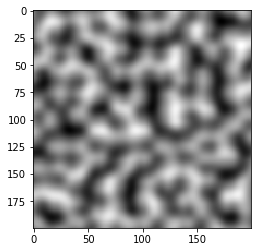

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product, count

from matplotlib.colors import LinearSegmentedColormap


# it produce more vectors pointing diagonally than vectors pointing along
# an axis
# # generate uniform unit vectors
# def generate_unit_vectors(n):
#     'Generates matrix NxN of unit length vectors'
#     v = np.random.uniform(-1, 1, (n, n, 2))
#     l = np.sqrt(v[:, :, 0] ** 2 + v[:, :, 1] ** 2).reshape(n, n, 1)
#     v /= l
#     return v

def generate_unit_vectors(n):
    'Generates matrix NxN of unit length vectors'
    phi = np.random.uniform(0, 2*np.pi, (n, n))
    v = np.stack((np.cos(phi), np.sin(phi)), axis=-1)
    return v


# quintic interpolation
def qz(t):
    return t * t * t * (t * (t * 6 - 15) + 10)


# cubic interpolation
def cz(t):
    return -2 * t * t * t + 3 * t * t


def generate_2D_perlin_noise(size, ns):
    '''
    generate_2D_perlin_noise(size, ns)
    Generate 2D array of size x size filled with Perlin noise.
    Parameters
    ----------
    size : int
        Size of 2D array size x size.
    ns : int
        Distance between nodes.
    Returns
    -------
    m : ndarray
        The 2D array filled with Perlin noise.
    '''
    nc = int(size / ns)  # number of nodes
    grid_size = int(size / ns + 1)  # number of points in grid

    # generate grid of vectors
    v = generate_unit_vectors(grid_size)

    # generate some constans in advance
    ad, ar = np.arange(ns), np.arange(-ns, 0, 1)

    # vectors from each of the 4 nearest nodes to a point in the NSxNS patch
    vd = np.zeros((ns, ns, 4, 1, 2))
    for (l1, l2), c in zip(product((ad, ar), repeat=2), count()):
        vd[:, :, c, 0] = np.stack(np.meshgrid(l2, l1, indexing='xy'), axis=2)

    # interpolation coefficients
    d = qz(np.stack((np.zeros((ns, ns, 2)),
                     np.stack(np.meshgrid(ad, ad, indexing='ij'), axis=2)),
           axis=2) / ns)
    d[:, :, 0] = 1 - d[:, :, 1]
    # make copy and reshape for convenience
    d0 = d[..., 0].copy().reshape(ns, ns, 1, 2)
    d1 = d[..., 1].copy().reshape(ns, ns, 2, 1)

    # make an empy matrix
    m = np.zeros((size, size))
    # reshape for convenience
    t = m.reshape(nc, ns, nc, ns)

    # calculate values for a NSxNS patch at a time
    for i, j in product(np.arange(nc), repeat=2):  # loop through the grid
        # get four node vectors
        av = v[i:i+2, j:j+2].reshape(4, 2, 1)
        # 'vector from node to point' dot 'node vector'
        at = np.matmul(vd, av).reshape(ns, ns, 2, 2)
        # horizontal and vertical interpolation
        t[i, :, j, :] = np.matmul(np.matmul(d0, at), d1).reshape(ns, ns)

    return m

img = generate_2D_perlin_noise(200, 20)
plt.imshow(img, cmap=cm.gray)

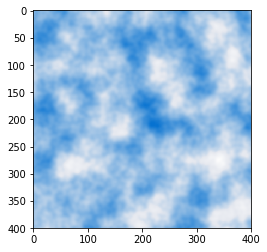

In [254]:
# Generate "sky" using multiple layers with different node distances
img0 = generate_2D_perlin_noise(400, 80)
img1 = generate_2D_perlin_noise(400, 40)
img2 = generate_2D_perlin_noise(400, 20)
img3 = generate_2D_perlin_noise(400, 10)

img = (img0 + img1 + img2 + img3) / 4
cmap = LinearSegmentedColormap.from_list('sky',
                                        [(0, '#0572D1'),
                                         (0.75, '#E5E8EF'),
                                         (1, '#FCFCFC')])
img = cm.ScalarMappable(cmap=cmap).to_rgba(img)
plt.imshow(img)

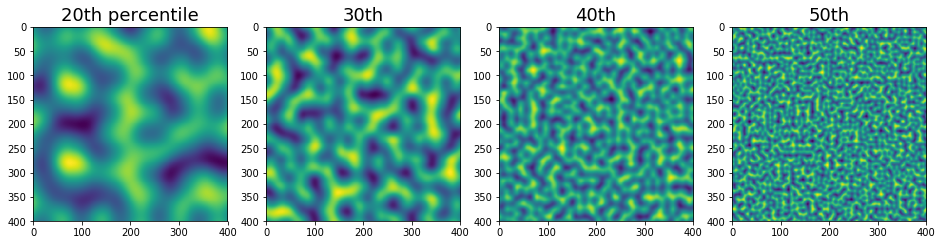

In [252]:
# Testing parameters of the noise generator

plt.figure(figsize=(16,16))
columns = 4
images = [img0, img1, img2, img3]
# images = [img0<0.8, img1<0.8, img2<0.8, img3<0.8]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

We can make a more realistic binary cloud mask by adding together multiple images generated with different node distances, and then thresholding the summed image. Thresholding by percentiles also conveniently gives us a range of different cloud covers that can be used to create the accuracy curve of the model.

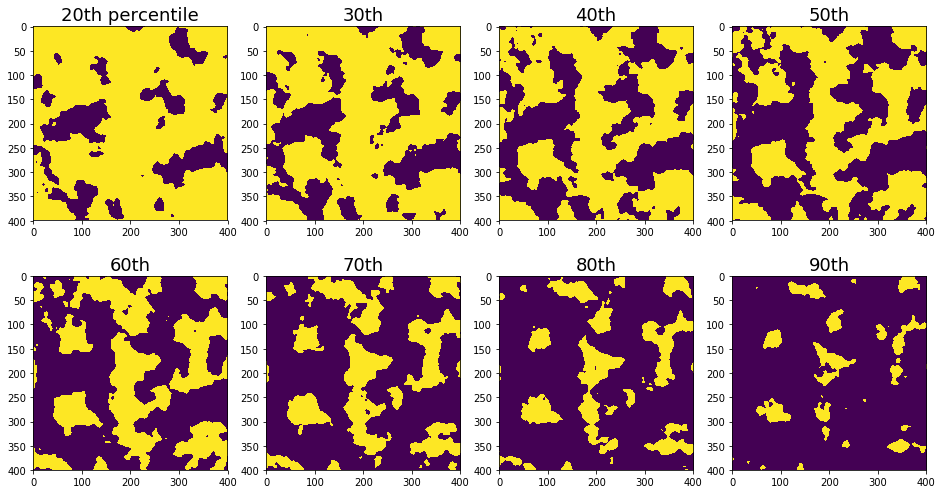

In [253]:
img_sum = np.sum(img, axis=2)

plt.figure(figsize=(16,13))
columns = 4
images = [img_sum>np.percentile(img_sum, 20),
          img_sum>np.percentile(img_sum, 30),
         img_sum>np.percentile(img_sum, 40),
          img_sum>np.percentile(img_sum, 50),
         img_sum>np.percentile(img_sum, 60),
          img_sum>np.percentile(img_sum, 70),
         img_sum>np.percentile(img_sum, 80),
         img_sum>np.percentile(img_sum, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

### Problem:
The code above only creates a square NxN matrix, whereas Landsat images are not square. We need NxM matrix. 

## 2-dimensional *non-square* Perlin noise generation
From https://github.com/caseman/noise

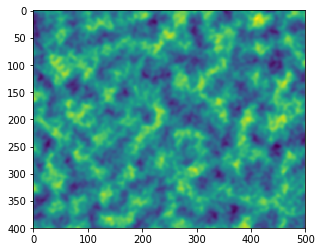

In [249]:
import sys
from noise import pnoise2, snoise2

myImg = np.zeros((400,500))
octaves = 3
freq = np.ceil(sqrt(450)) * octaves
for y in range(500):
    for x in range(400):
#         f.write("%s\n" % int(snoise2(x / freq, y / freq, octaves) * 127.0 + 128.0)
          myImg[x,y] = snoise2(x/freq, y/freq, octaves)      
plt.imshow(myImg)

## Cloud generation to mask Landsat imagery

Now let's generate Perlin noise large enough to cover an actual Landsat image

In [255]:
import rasterio
path = 'C:/Users/ipdavies/CPR/data/images/4337_LC08_026038_20160325_1/'
with rasterio.open(path+'stack/stack.tif') as ds:
    shape = ds.shape
    print(shape)

(3501, 4322)


Perlin noise for(3501, 4322)size image: 00:00:38.49


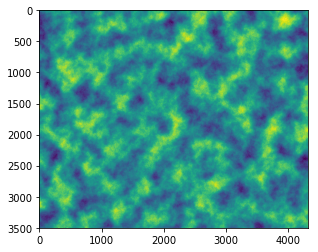

In [265]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask[x,y] = snoise2(x/freq, y/freq, octaves)      
            
plt.imshow(cloudMask)

print('Perlin noise for'+str(shape)+'size image: '+ timer(start_time, time.time()))

Perlin noise for(3501, 4322)size image: 00:00:47.46


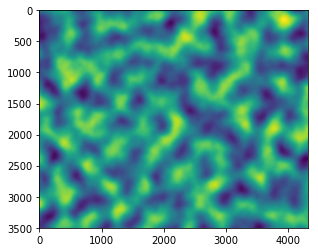

In [269]:
# Benchmark time
import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

start_time = time.time()

cloudMask2 = np.zeros(shape)
octaves = 10
freq = np.ceil(sqrt(np.sum(shape)/2)) * octaves
for y in range(shape[1]):
    for x in range(shape[0]):
          cloudMask2[x,y] = snoise2(x/freq, y/freq, octaves, persistence=0.2)      
            
plt.imshow(cloudMask2)

print('Perlin noise for'+str(shape)+'size image: '+ timer(start_time, time.time()))

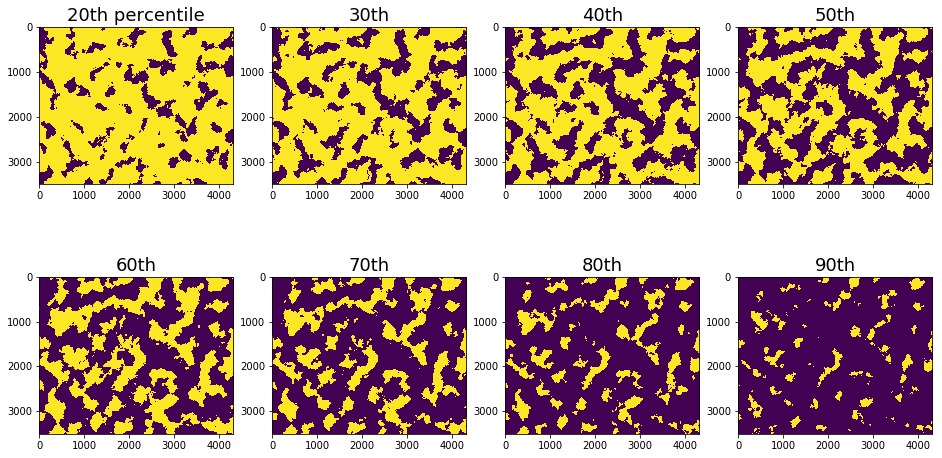

In [266]:
plt.figure(figsize=(16,13))
columns = 4
images = [cloudMask>np.percentile(cloudMask, 20),
          cloudMask>np.percentile(cloudMask, 30),
         cloudMask>np.percentile(cloudMask, 40),
          cloudMask>np.percentile(cloudMask, 50),
         cloudMask>np.percentile(cloudMask, 60),
          cloudMask>np.percentile(cloudMask, 70),
         cloudMask>np.percentile(cloudMask, 80),
         cloudMask>np.percentile(cloudMask, 90)]
titles = ['20th percentile', '30th','40th','50th',
         '60th','70th','80th','90th']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar